In [1]:
print("Iniciando el script de analisis candidatos neutrones...")
print("Importando librerias necesarias...")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from collections import defaultdict
import matplotlib.ticker as ticker
import glob
import os
import pickle
import sys
sys.path.append("/scratch/cgarcia_2002/Complete_analysis")
import functions_spills
import functions_analysis
import importlib
importlib.reload(functions_analysis)
importlib.reload(functions_spills)

from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

Iniciando el script de analisis candidatos neutrones...
Importando librerias necesarias...


In [2]:
with open('../Filtered_data/datos_filtrados.pkl', 'rb') as f:
    valores_read, indices_read = pickle.load(f)

with open('../Filtered_data/datos_filtrados_sig.pkl', 'rb') as f:
    valores_read_sig, indices_read_sig = pickle.load(f)

times_branch_filtered = functions_analysis.a_lista_de_arrays(valores_read, indices_read)
times_branch_filtered_sig = functions_analysis.a_lista_de_arrays(valores_read_sig, indices_read_sig)

print("Datos filtrados descargados")
N_events = len(times_branch_filtered)
N_events_sig = len(times_branch_filtered_sig)

print("Numero de eventos bkg", N_events)
print("Numero de eventos señal", N_events_sig)


Datos filtrados descargados
Numero de eventos bkg 157955
Numero de eventos señal 79586


In [41]:
deltaT = functions_analysis.deltaT_calculation('/scratch/cgarcia_2002/Complete_analysis/csv_saveData/Neutron_candidates/tRMS_Condition/neutron_candidates_150-300_22-30_1500.csv')

deltaT_sig = functions_analysis.deltaT_calculation('/scratch/cgarcia_2002/Complete_analysis/csv_saveData/Neutron_candidates/tRMS_Condition/neutron_candidates_sig_150-300_22-30_1500.csv')

In [42]:
print(len(deltaT))
print(len(deltaT_sig))
print(np.sqrt(len(deltaT_sig)))


153
354
18.81488772222678


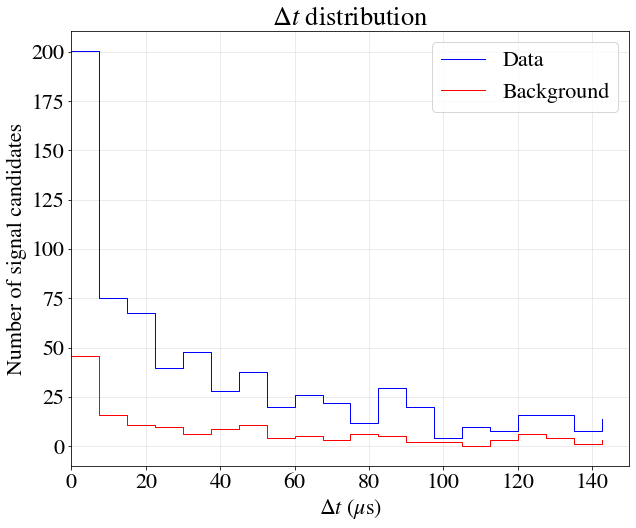

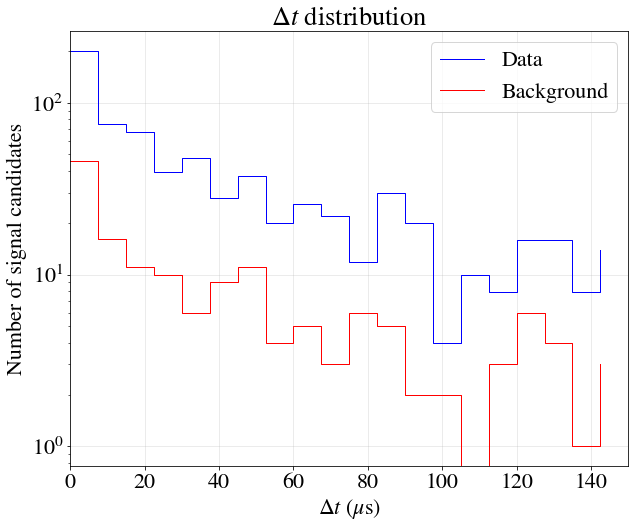

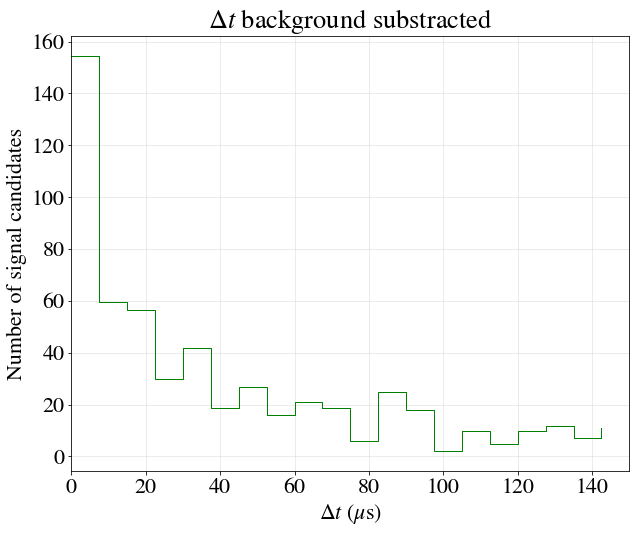

: 

In [ ]:
hist, bins_edges = np.histogram(deltaT, bins=20, range=(0, 150000))
hist_sig, _ = np.histogram(deltaT_sig, bins=bins_edges)

in_value = 10000
hist_filtered, bins_edges_filtered = np.histogram(deltaT, range=(in_value, 150000), bins=int((150000- in_value)/ 1000))
hist_sig_filtered, _ = np.histogram(deltaT_sig, bins=bins_edges_filtered)

plt.figure()
plt.step(bins_edges[:-1], hist_sig*N_events/N_events_sig, where='post', linewidth=1, label='Data', color='blue')
plt.step(bins_edges[:-1], hist, where='post', linewidth=1, label='Background', color='red')

plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ distribution')
plt.legend()
plt.xlim(0, 150000)
#plt.yscale('log')
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.show()

plt.figure()
plt.step(bins_edges[:-1], hist_sig*N_events/N_events_sig, where='post', linewidth=1, label='Data', color='blue')
plt.step(bins_edges[:-1], hist, where='post', linewidth=1, label='Background', color='red')
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ distribution')
plt.legend()
plt.xlim(0, 150000)
plt.yscale('log')
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.show()

plt.figure()
plt.step(bins_edges[:-1], hist_sig*N_events/N_events_sig - hist, where='post', linewidth=1, color='green')
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ background substracted')
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.xlim(0, 150000)
plt.show()


Ajuste: A = 91.20, tau = 46828.48
Ajuste: A = 17.51, tau = 52611.38


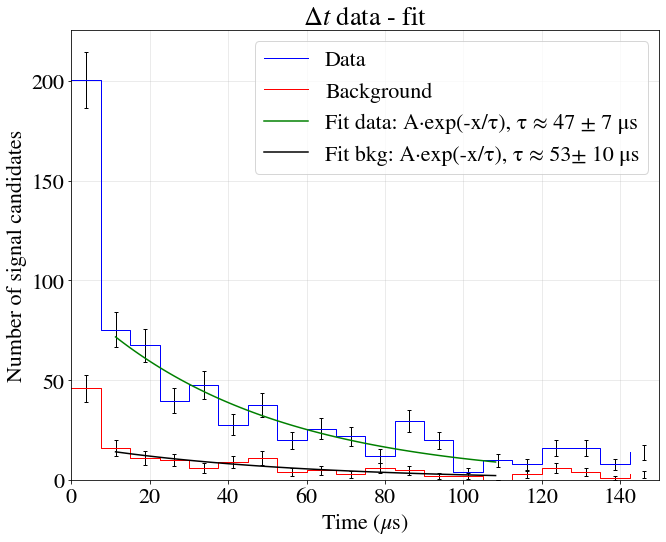

In [44]:
bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2  # calcular los centros de bin
data = hist_sig*N_events/N_events_sig
errors = np.sqrt(data)
# 3. Definir la función exponencial para el ajuste
def exp_func(x, A, tau):
    return A * np.exp(-x / tau)

popt, pcov = curve_fit(exp_func, bin_centers[1:-6], data[1:-6], p0=(max(data), 500))

# popt contiene los parámetros A y tau
A_fit, tau_fit = popt
A_err, tau_err = np.sqrt(np.diag(pcov))  # Error en A y tau

print(f"Ajuste: A = {A_fit:.2f}, tau = {tau_fit:.2f}")

popt_bkg, pcov_bkg = curve_fit(exp_func, bin_centers[1:-6], hist[1:-6], p0=(max(hist), 500))

# popt contiene los parámetros A y tau
A_fit_bkg, tau_fit_bkg = popt_bkg
A_err_bkg, tau_err_bkg = np.sqrt(np.diag(pcov_bkg))

print(f"Ajuste: A = {A_fit_bkg:.2f}, tau = {tau_fit_bkg:.2f}")

# 5. (Opcional) Graficar el histograma y el ajuste
plt.figure()
plt.step(bins_edges[:-1], data, where='post', linewidth=1, label='Data', color='blue')
plt.errorbar(bin_centers, data, yerr=errors, fmt='none', ecolor='black', elinewidth=1, capsize=2)

plt.step(bins_edges[:-1], hist, where='post', linewidth=1, label='Background', color='red')
plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist), fmt='none', ecolor='black', elinewidth=1, capsize=2)

x_fit = np.arange(int(bin_centers[1]), int(bin_centers[-6]), 1000)
plt.plot(x_fit, exp_func(x_fit, *popt), 'r-', label=f'Fit data: A·exp(-x/τ), τ ≈ {tau_fit/1000:.0f} ± {tau_err/1000:.0f} μs', color="green")
x_fit = np.arange(int(bin_centers[1]), int(bin_centers[-6]), 1000)
plt.plot(x_fit, exp_func(x_fit, *popt_bkg), 'r-', label=f'Fit bkg: A·exp(-x/τ), τ ≈ {tau_fit_bkg/1000:.0f}± {tau_err_bkg/1000:.0f} μs', color="black")
plt.xlabel(r'Time ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.grid(alpha=0.3)
plt.title(r'$\Delta t$ data - fit')
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.xlim(0, 150000)
plt.ylim(bottom = 0)
plt.show()


Ajuste: A = 69.51461304248812, tau = 50609.312560093196
Ajuste: A = 159.29752123489575, tau = 20002.93615264399


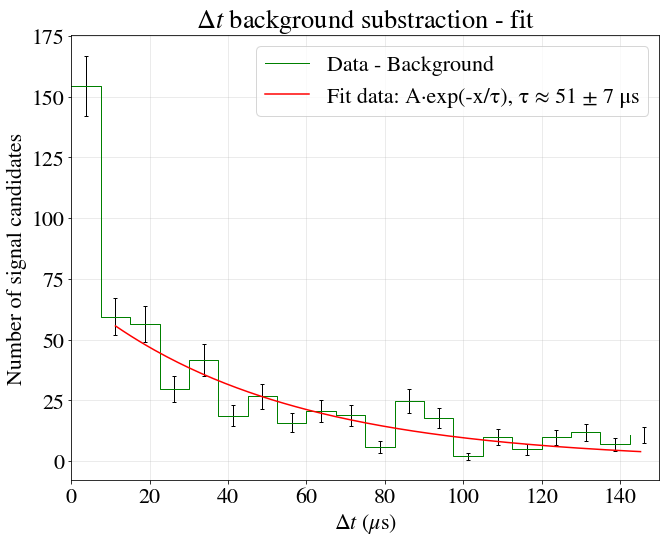

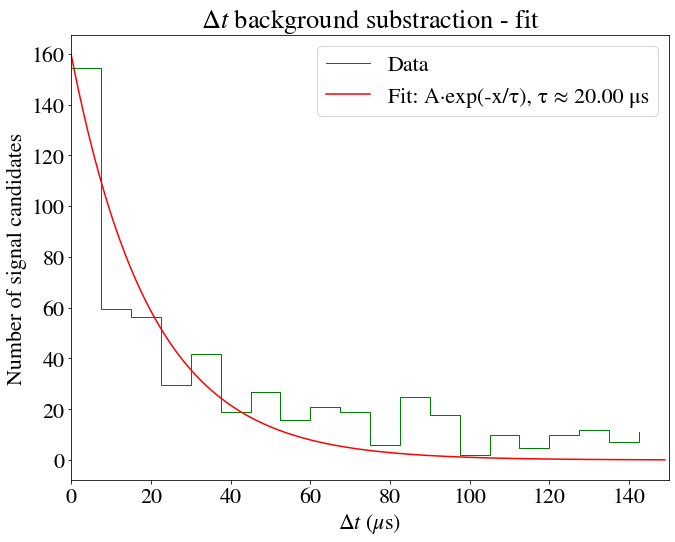

In [45]:
data = hist_sig*N_events/N_events_sig - hist
errors = np.sqrt(data)
popt, pcov = curve_fit(exp_func, bin_centers[1:], data[1:], p0=(max(data), 500))

# popt contiene los parámetros A y tau
A_fit, tau_fit = popt
A_err, tau_err = np.sqrt(np.diag(pcov))  # Error en A y tau
print(f"Ajuste: A = {A_fit}, tau = {tau_fit}")

plt.figure()
plt.step(bins_edges[:-1], data, where='post', linewidth=1, label='Data - Background', color='green')
plt.errorbar(bin_centers, data, yerr=errors, fmt='none', ecolor='black', elinewidth=1, capsize=2)

x_fit = np.arange(int(bin_centers[1]), int(bin_centers[-1]), 1000)
plt.plot(x_fit, exp_func(x_fit, *popt), 'r-', label=f'Fit data: A·exp(-x/τ), τ ≈ {tau_fit/1000:.0f} ± {tau_err/1000:.0f} μs')

plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ background substraction - fit')
plt.legend()
plt.tight_layout()
plt.xlim(0, 150000)
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.savefig('/scratch/cgarcia_2002/Complete_analysis/Plots/DeltaT/DeltaT_FitBkgSubstraction.png', facecolor='white')

popt, pcov = curve_fit(exp_func, bin_centers, data, p0=(max(data), 500))

# popt contiene los parámetros A y tau
A_fit, tau_fit = popt
print(f"Ajuste: A = {A_fit}, tau = {tau_fit}")

plt.figure()
plt.step(bins_edges[:-1], data, where='post', linewidth=1, label='Data', color='green')
x_fit = np.arange(0, 150000, 1000)
plt.plot(x_fit, exp_func(x_fit, *popt), 'r-', label=f'Fit: A·exp(-x/τ), τ ≈ {tau_fit/1000:.2f} μs')
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ background substraction - fit')
plt.legend()
plt.tight_layout()
plt.xlim(0, 150000)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.savefig('/scratch/cgarcia_2002/Complete_analysis/Plots/DeltaT/DeltaT_FitBkgSubstraction.png', facecolor='white')



Ajuste: A = 51.76498568371084, tau = 870.0384129114648


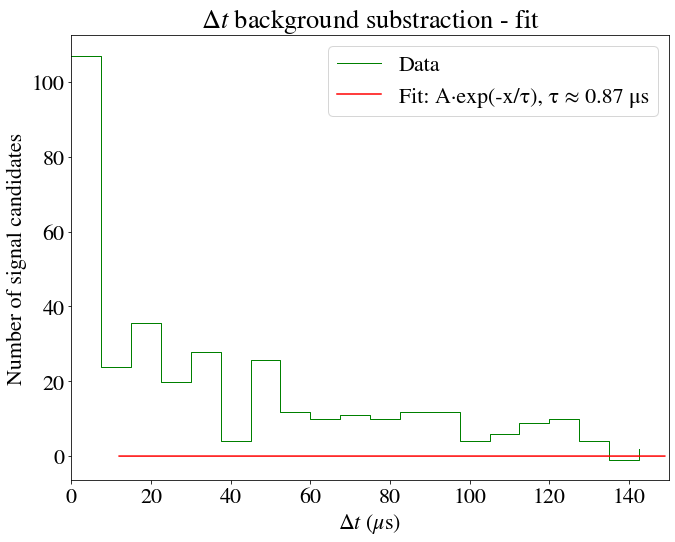

In [39]:

bin_centers_filtered = (bins_edges_filtered[:-1] + bins_edges_filtered[1:]) / 2  # calcular los centros de bin
data_filtered = hist_sig_filtered*N_events/N_events_sig - hist_filtered

popt, pcov = curve_fit(exp_func, bin_centers_filtered, data_filtered, p0=(max(data_filtered), 500))

# popt contiene los parámetros A y tau
A_fit, tau_fit = popt
print(f"Ajuste: A = {A_fit}, tau = {tau_fit}")

plt.figure()
plt.step(bins_edges[:-1], data, where='post', linewidth=1, label='Data', color='green')
x_fit = np.arange(12000, 150000, 1000)
plt.plot(x_fit, exp_func(x_fit, *popt), 'r-', label=f'Fit: A·exp(-x/τ), τ ≈ {tau_fit/1000:.2f} μs')
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ background substraction - fit')
plt.legend()
plt.tight_layout()
plt.xlim(0, 150000)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.savefig('/scratch/cgarcia_2002/Complete_analysis/Plots/DeltaT/DeltaT_FitBkgSubstraction.png', facecolor='white')


In [9]:
directory = "Neutron_candidates/Tests_WindowSize"
csv_files = glob.glob(os.path.join(directory, "*.csv"))
print(csv_files)
# Lista de listas
deltaT_total = {}
delatT_total_sig = {}

# Recorrer todos los CSV y aplicar la función
for file in csv_files:
    nombre = os.path.basename(file)
    
    print(f"Procesando {nombre}")
    deltaT_result = functions_analysis.deltaT_calculation(file)
    if "sig" in nombre:  
        key_file = nombre.replace("neutron_candidates_sig_10-50_", "").replace(".csv", "")  
        delatT_total_sig[key_file] = deltaT_result
    else:
        key_file = nombre.replace("neutron_candidates_10-50_", "").replace(".csv", "")  
        deltaT_total[key_file] = deltaT_result

print("Proceso completado.")

[]
Proceso completado.


In [10]:
tau_dict = {}

for key in deltaT_total:
    deltaT = deltaT_total[key]
    deltaT_sig = delatT_total_sig[key]
    
    hist, bins_edges = np.histogram(deltaT, bins=50, range=(0, 150000))
    hist_sig, _ = np.histogram(deltaT_sig, bins=bins_edges)

    bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2  # calcular los centros de bin
    data = hist_sig*N_events/N_events_sig - hist

    popt, pcov = curve_fit(exp_func, bin_centers, data, p0=(max(data), 500))

    # popt contiene los parámetros A y tau
    A_fit, tau_fit = popt
    print(f"Ajuste: A = {A_fit}, tau = {tau_fit}")

    tau_dict[key] = tau_fit


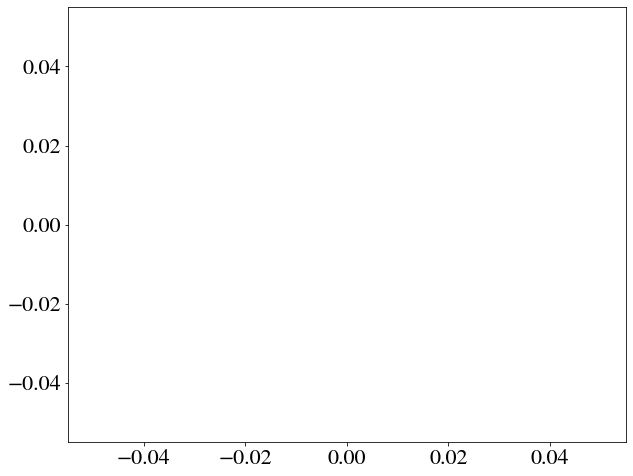

In [11]:
tau_dict.values()
plt.figure()
plt.plot(tau_dict.values())
plt.show()

In [12]:
spills_bkg= 62209
spills_sig = 29764

error_bkg = np.sqrt(spills_bkg)
error_sig = np.sqrt(spills_sig)

ratio_bkg = spills_bkg / N_events
ratio_sig = spills_sig / N_events_sig

error_ratio_bkg = error_bkg / N_events
error_ratio_sig = error_sig / N_events_sig

print("Spills background:", spills_bkg)
print("Spills signal:", spills_sig)
print("Error spills bkg", error_bkg)
print("error spills sig", error_sig)
print("Ratio background:", ratio_bkg)
print("Ratio signal:", ratio_sig)
print("Error background:", error_ratio_bkg)
print("Error signal:", error_ratio_sig)

total_s = N_events * 270 / 10**6
total_s_sig = N_events_sig * 270 / 10**6

print("segundos totales", total_s, total_s_sig)
print("actvidad bkg", spills_bkg / total_s, error_bkg / total_s)
print("actvidad data", spills_sig / total_s_sig, error_sig / total_s_sig)

Spills background: 62209
Spills signal: 29764
Error spills bkg 249.4173209702967
error spills sig 172.52246230563716
Ratio background: 0.3938400177265677
Ratio signal: 0.3739853743120649
Error background: 0.0015790403657389553
Error signal: 0.0021677488792706903
segundos totales 42.64785 21.48822
actvidad bkg 1458.6667323206211 5.84829765088502
actvidad data 1385.131015970611 8.028699552854409
